# Creating arrays along the coast

In [1]:
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds
from MITgcmutils import mds
from MITgcmutils import diagnostics
import numpy as np
import sys
sys.ps1 = 'SOMETHING'
import matplotlib.pyplot as plt
import matplotlib.dates as dat
from matplotlib import cm
import cmocean
import xarray as xr
from math import radians, cos, sin, asin, sqrt
import netCDF4 as nc
import warnings
import pylab as pl
from time import sleep
warnings.filterwarnings("ignore")


## Doing the picking out 

In [2]:
def findlonlat(hFacCuse,d,var):

    nx = 512
    ny = 612
    ind30=170+50 #30° N
    indlon = 50 # Lon of land at N boundary

    lon_inds_off = np.argmax(np.squeeze(hFacCuse[d,:,::-1]), axis=1)


    lon_inds = np.ones_like(lon_inds_off[ind30:])*nx - lon_inds_off[ind30:]
    lat_inds = np.ones_like(lon_inds)*ind30 + np.arange(len(lon_inds))

    lat_inds_off = np.argmax(np.squeeze(hFacCuse[d,::-1,:]), axis=0)



    lat_inds_2 = np.ones_like(lat_inds_off[indlon:])*ny - lat_inds_off[indlon:]
    lon_inds_2 = np.ones_like(lat_inds)*indlon + np.arange(len(lat_inds))

    p=0

    k=np.ones_like(lon_inds)
    l=np.ones_like(lat_inds)

    for i in np.arange(len(lon_inds_2)):
        if lon_inds_2[i] not in lon_inds:
            p=p+1
            k[p]=lon_inds_2[i]
            l[p]=lat_inds_2[i]
        
    k=k[k!=1]
    l=l[l!=1]
    
    # Fill the holes
    holearray=[]
    for i in np.arange(len(l)):
        if l[i] not in holearray:
            indexpts=np.where(lat_inds==l[i])
            indexs=np.where(l==lat_inds[indexpts[0]])
            lon_inds=np.insert(lon_inds,indexpts[0],k[indexs])
            lat_inds=np.insert(lat_inds,indexpts[0],l[indexs])
            holearray.append(l[i])
    
    #Organize where the values are in the wrong order
    if var==1:
        lon_lat=np.zeros((2,len(lon_inds[332:436])))
        lon_lat[0,:]=lat_inds[332:436]
        lon_lat[1,:]=lon_inds[332:436]

        inds=lon_lat[1, :].argsort()
        indices=np.flip(inds)

        latis=lon_lat[0,indices]
        lonis=lon_lat[1,indices]

        lat_inds[332:436]=latis
        lon_inds[332:436]=lonis

    print("Done")
    
    return(lat_inds, lon_inds)

######   Calculate the great circle distance in kilometers between two points on the earth (specified in decimal degrees)

In [3]:
def haversine(lon1, lat1, lon2, lat2):

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [7]:
#For SSH 
def loadingcoastpts(hFacCuse,Z,prevalue,name,name2,name3,nt,t,FILENAME):

    dep=0
    lat_fix, lon_fix=findlonlat(hFacCuse,dep)


    dist_array = np.zeros(len(lon_fix))
    p=0
    for jj,ii in zip(lon_fix, lat_fix):
        lat1 = LAT[ii-2]
        lon1 = LON[jj-2]
        lat2 = LAT[ii-1]
        lon2 = LON[jj-1]
        p=p+1
        dist_array[p-1]=  haversine(lat1, lon1, lat2, lon2)
    
    dist_cummul = np.cumsum(dist_array)
    
    value=prevalue.values
    val = np.zeros((nt,len(lon_fix)))
    
    p=0
    
    for ii,jj in zip(lon_fix, lat_fix):
        p=p+1
        val[:,p-1] = value[:,jj-1,ii-1]
     
    ds = xr.Dataset({name: (("time","x"), val),
                    name2:(("x"), lon_fix),
                    name3:(("x"), lat_fix)
                    },
                    coords ={
                    "x" : dist_cummul,
                    "time": t,
                    },
                   )
    
    ds.to_netcdf(FILENAME)

#For dynvars and pressure, just don't forget to change the depth
def varsalongcoasts(hFacCuse,LAT,LON,Z,valvar,name,name2,name3,nt,t,FILENAME):

    dep=55
    lat_fix, lon_fix=findlonlat(hFacCuse,dep,1)
    
    dist_array = np.zeros(len(lon_fix[5:-5]))
    p=0
    for ii,jj in zip(lon_fix[5:-5],lat_fix[5:-5]):
        lat1 = LAT[jj-2]
        lon1 = LON[ii-2]
        lat2 = LAT[jj-1]
        lon2 = LON[ii-1]
        p=p+1
        dist_array[p-1]=  haversine(lat1, lon1, lat2, lon2)

    dist_cummul = np.cumsum(dist_array)
    rangedep=np.arange(0,71,10)
    val = np.zeros((nt,len(lon_fix[5:-5]))) 
    dd=0

    for h in range(nt):
        p=0
        for n in np.arange(5,len(lon_fix)-5,1):
            p=p+1
            
            value=np.mean(valvar[h-1,lat_fix[n-5:n+5]-1,lon_fix[n-5:n+5]-1])
            val[h-1,p-1] = value

    lon_fix=lon_fix[5:-5]
    lat_fix=lat_fix[5:-5]
    
    ds = xr.Dataset({name: (("time","x"), val),                 
                     name2:(("x"), lon_fix),
                     name3:(("x"), lat_fix)
                    },
                coords ={
                    "x" : dist_cummul,
                    "time": t,
                },
                )
    ds.to_netcdf(FILENAME)
    
# When you want a diagonal across the area    
def varsalldepths(hFacCuse,LAT,LON,Z,valvar,name,name2,name3,nt,t,FILENAME):
    Zdyn=Z[:71].values
    
    
    latss=LAT.values
    leo=np.arange(4,590,4)
    LATSpre=np.delete(latss,np.arange(0,10,1))
    LATSpre=np.delete(LATSpre,leo)

    lat_ind=np.zeros(455)
    for i in np.arange(0,455,1):
        indexx=np.where(latss==LATSpre[i])
        lat_ind[i]=indexx[0]
    
    lon_ind=np.flip(np.arange(10,445,1))
    lat_ind=lat_ind[10:-10].astype(int)


    dist_array = np.zeros(len(lon_ind))
    p=0
    for ii,jj in zip(lon_ind,lat_ind):
        lat1 = LAT[jj-2]
        lon1 = LON[ii-2]
        lat2 = LAT[jj-1]
        lon2 = LON[ii-1]
        p=p+1
        dist_array[p-1]=  haversine(lat1, lon1, lat2, lon2)

    dist_cummul = np.cumsum(dist_array)
    rangedep=np.arange(0,71,10)
    val = np.zeros((nt,len(Zdyn[rangedep]),len(lon_ind))) 
    dd=0
    
    for dep in rangedep:
        dd=dd+1
        for h in range(nt):
            p=0
            for ii,jj in zip(lon_ind,lat_ind):
                p=p+1
                value=valvar[h-1,dep,jj-1,ii-1]
                val[h-1,dd-1,p-1] = value
            

    ds = xr.Dataset({name: (("time","z","x"), val),                 
                     name2:(("x"), lon_ind),
                     name3:(("x"), lat_ind)
                    },
                coords ={
                    "x" : dist_cummul,
                    "z" : Zdyn[rangedep],
                    "time": t,
                },
                )
    ds.to_netcdf(FILENAME)

#### Loading NetCDF files of the dynvars

In [5]:
def loadNetCDFs(varname):
    dsw=[]
    dsn=[]
    for i in np.arange(0,8,1):
        
        if varname=='DYNVARS':
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        else:
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)
        
        dsw.append(dswin)
        dsn.append(dsnin)
        
    return dsw, dsn

In [6]:
dsw,dsn=loadNetCDFs('DYNVARS')

#### For Vertical hovmöller plots

In [17]:
hej=[58,65, 111, 125, 130, 205,220, 267,278, 299, 360,405] # These are the indexes where the values are a bit odd
#The following is to get the wanted indexes and Z values
varname='WVEL'
i=1
pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'
dswpts  = xr.open_dataset(pathw)
lonind=dswpts.lonAC
latind=dswpts.latAC

varname='DYNVARS'
path='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
dswdep  = xr.open_dataset(path)

Z=dswdep.Z.values

In [18]:
for l in np.arange(len(hej)):
    l=0
    FILENAME=f'WVELvertical{hej[l]}.nc'

    var23=dsw[0].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var34=dsw[1].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var45=dsw[2].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var56=dsw[3].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var67=dsw[4].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var78=dsw[5].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var89=dsw[6].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var910=dsw[7].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values

    Ww=np.concatenate((var23, var34, var45, var56,var67,var78,var89, var910), axis=0)# , ,var910), axis=0) 
    print('With bay one is done')

    var23n=dsn[0].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var34n=dsn[1].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var45n=dsn[2].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var56n=dsn[3].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values                
    var67n=dsn[4].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var78n=dsn[5].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var89n=dsn[6].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values
    var910n=dsn[7].WVEL[:,:,latind[hej[l]],lonind[hej[l]]].values

    Wn=np.concatenate((var23n, var34n, var45n, var56n,var67n,var78n,var89n, var910n), axis=0) #, var910n), axis=0) 
    print('Without bay one is done')

    time23=dsw[0].time.values.astype(int)
    time34=dsw[1].time.values.astype(int)
    time45=dsw[2].time.values.astype(int)
    time56=dsw[3].time.values.astype(int)
    time67=dsw[4].time.values.astype(int)
    time78=dsw[5].time.values.astype(int)
    time89=dsw[6].time.values.astype(int)
    time910=dsw[7].time.values.astype(int)

    Time=np.concatenate((time23, time34, time45, time56,time67, time78,time89, time910), axis=0)#, time910), axis=0)

    times=Time*1e-9

    ds = xr.Dataset({'Ww': (("time","z"), Ww),
                     'Wn': (("time","z"), Wn)
                    },
                    coords ={
                        "z" : Z,
                        "time": times,
                    },
                   )
    ds.to_netcdf(FILENAME)

With bay one is done
Without bay one is done


### To save all velocity along the coast

In [141]:
LAT=dsw[0].YC
LON=dsw[0].XC-360
Zdyn = dsw[0].Z
hFacCw = dsw[0].hFacC
hFacCn = dsn[0].hFacC
hFacCusew=hFacCw.values
hFacCusen=hFacCn.values

varname='WVEL'

for l in np.arange(0,8,1):
    pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'
    pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'

    Ww=dsw[l].WVEL[:,55,:,:].values
    Wn=dsn[l].WVEL[:,55,:,:].values

    TIMEdyn=dsw[l].time
    ntdyn = np.size(TIMEdyn)

    varsalongcoasts(hFacCusew,LAT,LON,Zdyn,Ww,'Ww','lonAC','latAC',ntdyn,TIMEdyn,pathw)
    varsalongcoasts(hFacCusen,LAT,LON,Zdyn,Wn,'Wn','lonAC','latAC',ntdyn,TIMEdyn,pathn)



Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [9]:
LAT=dsw[0].YC
LON=dsw[0].XC-360
Zdyn = dsw[0].Z
hFacCw = dsw[0].hFacC
hFacCn = dsn[0].hFacC
hFacCusew=hFacCw.values
hFacCusen=hFacCn.values

varname='VVEL'

for l in np.arange(0,8,1):
    pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'
    pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'

    Vw=dsw[l].VVEL[:,55,:,:].values
    Vn=dsn[l].VVEL[:,55,:,:].values

    TIMEdyn=dsw[l].time
    ntdyn = np.size(TIMEdyn)

    varsalongcoasts(hFacCusew,LAT,LON,Zdyn,Vw,'Vw','lonAC','latAC',ntdyn,TIMEdyn,pathw)
    varsalongcoasts(hFacCusen,LAT,LON,Zdyn,Vn,'Vn','lonAC','latAC',ntdyn,TIMEdyn,pathn)



Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [12]:
LAT=dsw[0].YC
LON=dsw[0].XC-360
Zdyn = dsw[0].Z
hFacCw = dsw[0].hFacC
hFacCn = dsn[0].hFacC
hFacCusew=hFacCw.values
hFacCusen=hFacCn.values

varname='UVEL'

for l in np.arange(0,8,1):

    pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'
    pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'

    Uw=dsw[l].UVEL[:,55,:,:].values
    Un=dsn[l].UVEL[:,55,:,:].values

    TIMEdyn=dsw[l].time
    ntdyn = np.size(TIMEdyn)

    varsalongcoasts(hFacCusew,LAT,LON,Zdyn,Uw,'Uw','lonAC','latAC',ntdyn,TIMEdyn,pathw)
    varsalongcoasts(hFacCusen,LAT,LON,Zdyn,Un,'Un','lonAC','latAC',ntdyn,TIMEdyn,pathn)


Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


# SSH 

In [9]:
data_dirWITH= '/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'
data_dirNO= '/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'

In [10]:
iters = np.arange(2880,14400,20)
dsn=open_mdsdataset(data_dirNO,data_dirNO,prefix=['eta'],default_dtype='>f4',iters=iters)

In [11]:
iters = np.arange(2880,14400,20)

dsw=open_mdsdataset(data_dirWITH,data_dirWITH,prefix=['eta'],default_dtype='>f4',iters=iters)

In [6]:
etaw=dsw.ETAN
etan=dsn.ETAN


Zeta = dsw.Z
TIMEeta=dsw.time
nteta = np.size(TIMEeta)

depth = dsw.Depth
LAT = dsw.YC
LON = dsw.XC-360

hFacCw = dsw.hFacC
hFacCn = dsn.hFacC


maskcw=dsw.maskInC==False
maskcn=dsn.maskInC==False


ind30=170+50 #30° N
ind307=170+100 #30.7° N
ind314=170+150 #31.4° N
ind32=170+200 #32° N

indlon = 50 # Lon of land at N boundary

nx = 512
ny = 612
nz = 100

hFacCuse=hFacCw.values

In [212]:
loadingcoastpts(hFacCuse,Zeta,etaw,'ETA','lonAC','latAC',nteta,TIMEeta,'/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/ETAwithSVBACall.nc')
loadingcoastpts(hFacCuse,Zeta,etan,'ETA','lonAC','latAC',nteta,TIMEeta,'/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/ETAnoSVBACall.nc')

Done
Done


# Pressure 

In [7]:
data_dirWITH= '/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'

levels=np.arange(0,76,1)
dsw=open_mdsdataset(data_dirWITH,data_dirWITH,prefix=['phiHyd'],levels=levels,default_dtype='>f4')

Pw=dsw.PHIHYD #Hydrostatic ressure in m^2/s^2
depth=dsw.Depth #Depth in m over x and y
TIMEw=dsw.time #Time in minutes from day 2 until day 10 with time step 1 day
ntw = np.size(TIMEw) #How many time steps
Z=dsw.Z[:71] #Depth in m

dswbot=open_mdsdataset(data_dirWITH,data_dirWITH,prefix=['phiBot'],levels=levels,default_dtype='>f4',ignore_unknown_vars=True)
Pwbot=dswbot.PHIBOT

In [8]:
data_dirNO= '/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'
levels=np.arange(0,76,1)
dsn=open_mdsdataset(data_dirNO,data_dirNO,prefix=['phiHyd'],levels=levels,default_dtype='>f4')
Pn=dsn.PHIHYD

dsnbot=open_mdsdataset(data_dirNO,data_dirNO,prefix=['phiBot'],levels=levels,default_dtype='>f4')
Pnbot=dsnbot.PHIBOT

In [44]:
Pw=Pwbot.values

In [45]:
Pn=Pnbot.values

In [42]:
Zp=dswbot.Z
TIMEp=dsnbot.time
nt = np.size(TIMEp)

depth = dswbot.Depth
LAT = dswbot.YC
LON = dswbot.XC-360

hFacCw = dswbot.hFacC
hFacCn = dsnbot.hFacC


maskcw=dsw.maskInC==False
maskcn=dsn.maskInC==False


ind30=170+50 #30° N
ind307=170+100 #30.7° N
ind314=170+150 #31.4° N
ind32=170+200 #32° N

indlon = 50 # Lon of land at N boundary

nx = 512
ny = 612
nz = 100

hFacCusew=hFacCw.values
hFacCusen=hFacCn.values

In [43]:
varname='PBOT'
pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'ACnoSVB.nc'
pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'ACwithSVB.nc'

varsalongcoasts(hFacCusew,LAT,LON,Zp,Pw,'PwBot','lonAC','latAC',nt,TIMEp,pathw)
varsalongcoasts(hFacCusen,LAT,LON,Zp,Pn,'PnBot','lonAC','latAC',nt,TIMEp,pathn)


Done
Done


In [ ]:
dsw,dsn=loadNetCDFs('PHIHYD')

In [9]:
LAT=dsw[0].YC
LON=dsw[0].XC-360
Zp = dsw[0].Z
hFacCw = dsw[0].hFacC
hFacCn = dsn[0].hFacC
hFacCusew=hFacCw.values
hFacCusen=hFacCn.values

varname='PHIHYD'

for l in np.arange(0,8,1):
    pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'
    pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'

    Pw=dsw[l].PHIHYD[:,55,:,:].values
    Pn=dsn[l].PHIHYD[:,55,:,:].values

    TIMEp=dsw[l].time
    ntp = np.size(TIMEp)

    varsalongcoasts(hFacCusew,LAT,LON,Zp,Pw,'Pw','lonAC','latAC',ntp,TIMEp,pathw)
    varsalongcoasts(hFacCusen,LAT,LON,Zp,Pn,'Pn','lonAC','latAC',ntp,TIMEp,pathn)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


## Density

In [8]:
dswrho,dsnrho=loadNetCDFs('RHO')

In [12]:
LAT=dswrho[0].YC
LON=dswrho[0].XC-360
Zdyn = dswrho[0].Z
hFacCw = dswrho[0].hFacC
hFacCn = dsnrho[0].hFacC
hFacCusew=hFacCw.values
hFacCusen=hFacCn.values

varname='RHO'

for l in np.arange(0,8,1):
    pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'
    pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+l)+'_'+ str(3+l) +'all.nc'

    rhow=dswrho[l].RHOAnoma[:,55,:,:].values
    rhon=dsnrho[l].RHOAnoma[:,55,:,:].values

    TIMEdyn=dswrho[l].time
    ntdyn = np.size(TIMEdyn)

    varsalongcoasts(hFacCusew,LAT,LON,Zdyn,rhow,'rhow','lonAC','latAC',ntdyn,TIMEdyn,pathw)
    varsalongcoasts(hFacCusen,LAT,LON,Zdyn,rhon,'rhon','lonAC','latAC',ntdyn,TIMEdyn,pathn)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


## Plot the points

In [17]:
LAT=dsw.YC
LON=dsw.XC-360
Zdyn = dsw.Z
hFacCw = dsw.hFacC
hFacCn = dsn.hFacC
hFacCusew=hFacCw.values
hFacCusen=hFacCn.values
depth = dsw.Depth

In [14]:
lat_inds, lon_inds=findlonlat(hFacCusew,10,1)

Done


In [15]:
params = {'font.size': 18,
          'figure.figsize': (30, 30),
         'font.family':'serif'}
pl.rcParams.update(params)

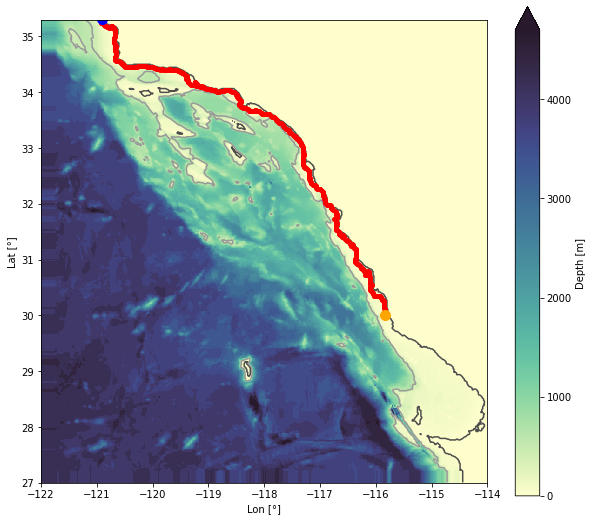

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.pcolormesh(LON,LAT,depth, cmap=cmocean.cm.deep)#, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(LON,LAT,depth, colors=['0.3','0.6'], 
                levels=[0,500])

for ii,jj in zip(lon_inds,lat_inds):

    ax.plot(LON[ii-1],LAT[jj-1],'o', 
            markersize=4, color='r')

# To show it begins and ends where it should
ax.plot(LON[lon_inds[0]],LAT[lat_inds[0]],'o', 
           markersize=10, color='orange') 
ax.plot(LON[lon_inds[-1]],LAT[lat_inds[-1]],'o', 
           markersize=10, color='blue') 



cb.set_label('Depth [m]')
ax.set_xlabel('Lon [°]')
ax.set_ylabel('Lat [°]')
ax.set_xlim(238-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

### Filling the holes by hand
Attempted, Does not work

In [ ]:
[58 111 125:130 205 267:299 360:405] #Indices for weird values in the hovmoller

In [402]:
lon_inds=np.insert(lon_inds,261,k[145]) #k[145:152]k[155:161]
lat_inds=np.insert(lat_inds,261,l[145])

In [320]:
lon_inds=np.insert(lon_inds,153,k[132])
lat_inds=np.insert(lat_inds,153,l[132])

In [443]:
lon_inds=np.insert(lon_inds,310,k[182]) #182 and 183
lat_inds=np.insert(lat_inds,310,l[182])

In [485]:
lon_inds=np.insert(lon_inds,316,k[191:241])
lat_inds=np.insert(lat_inds,316,l[191:241])

In [486]:
lon_inds=np.insert(lon_inds,316,k[259:273])
lat_inds=np.insert(lat_inds,316,l[259:273])

In [518]:
while all(x<=y for x, y in zip(dist_array, dist_array[1:])) == False:
    for i in np.arange(np.size(dist_array)):

        if np.any(dist_array[:i]>dist_array[i]):
            plonki=np.where(dist_array[:i]>dist_array[i])
            plonk=plonki[0][0]
            distval=dist_array[i]
            dist_array=np.delete(dist_array,i)
            dist_array=np.insert(dist_array,plonk,distval)
            
            lonval=lon_inds[i]
            lon_inds=np.delete(lon_inds,i)
            lon_inds=np.insert(lon_inds,plonk,lonval)
            
            latval=lat_inds[i]
            lat_inds=np.delete(lat_inds,i)
            lat_inds=np.insert(lat_inds,plonk,latval)
            #print(i)


In [ ]:
for ii,jj in zip(lon_fix,lat_fix):
    if depth[jj-1,ii-1] == 0:
        lon_fix[np.where(lon_fix == ii)]=ii-1
        lat_fix[np.where(lat_fix == jj)]=jj-1
        print(str(depth[jj-2,ii-2].values))
        

In [106]:
def findlonlat(hFacCuse,d,var):

    nx = 512
    ny = 612
    ind30=150 #30° N Write 150 later to get in the bay too
    indlon = 50 # Lon of land at N boundary

    lon_inds_off = np.argmax(np.squeeze(hFacCuse[d,:,::-1]), axis=1)


    lon_inds = np.ones_like(lon_inds_off[ind30:])*nx - lon_inds_off[ind30:]
    lat_inds = np.ones_like(lon_inds)*ind30 + np.arange(len(lon_inds))

    lat_inds_off = np.argmax(np.squeeze(hFacCuse[d,::-1,:]), axis=0)



    lat_inds_2 = np.ones_like(lat_inds_off[indlon:])*ny - lat_inds_off[indlon:]
    lon_inds_2 = np.ones_like(lat_inds)*indlon + np.arange(len(lat_inds))

    p=0

    k=np.ones_like(lon_inds)
    l=np.ones_like(lat_inds)

    for i in np.arange(len(lon_inds_2)):
        if lon_inds_2[i] not in lon_inds:
            p=p+1
            k[p]=lon_inds_2[i]
            l[p]=lat_inds_2[i]
        
    k=k[k!=1]
    l=l[l!=1]
    
    # Fill the holes
    korvarray=[]
    for i in np.arange(len(l)):
        if l[i] not in korvarray:
            indexpts=np.where(lat_inds==l[i])
            indexs=np.where(l==lat_inds[indexpts[0]])
            lon_inds=np.insert(lon_inds,indexpts[0],k[indexs])
            lat_inds=np.insert(lat_inds,indexpts[0],l[indexs])
            korvarray.append(l[i])
    
    #Organize where the values are in the wrong order
    if var==1:
        lon_lat=np.zeros((2,len(lon_inds[332:436])))
        lon_lat[0,:]=lat_inds[332:436]
        lon_lat[1,:]=lon_inds[332:436]

        inds=lon_lat[1, :].argsort()
        indices=np.flip(inds)

        latis=lon_lat[0,indices]
        lonis=lon_lat[1,indices]

        lat_inds[332:436]=latis
        lon_inds[332:436]=lonis
        
    hej= [77, 115, 126, 140, 148, 161, 163, 213, 219, 224, 226, 228, 277,
       278, 283, 285, 289, 290, 292, 308, 364, 375, 377, 378, 381, 385,
       391, 397, 400, 403, 409, 420, 436, 437, 438, 439, 442, 444, 446,
       449, 451, 453, 455, 459, 461, 477, 484, 524]
    
    hej=np.array(hej)
    
    lat_inds=np.delete(lat_inds,hej)
    lon_inds=np.delete(lon_inds,hej)
    print("Done")
    
    return(lat_inds, lon_inds)